In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import pickle
import argparse
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
import sys
import datetime
from pathlib import Path
import seaborn as sns
import time
from Bio import SeqIO
from torch.utils.data import DataLoader
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from config import *
import util.misc as utils
from models.nt_classifier import build as build_model
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
model_name = 'all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_splashPARISFINETUNINGtrainhqRICSEQval0060_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0083'

In [4]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', model_name)#'binary_cl2')

# Define the path to the file containing the args namespace
args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') 

In [5]:
pairs_path = os.path.join('/data01/giorgio/RNARNA-NT/dataset/external_dataset/paris_windows_subset')

df = pd.read_csv(os.path.join(pairs_path, 'pairs.csv'))

embedding_dir = os.path.join(os.path.join(pairs_path, 'embeddings', '32')) #/data01/giorgio/RNARNA-NT/dataset/external_dataset/paris_windows_subset/embeddings/

In [6]:
device = torch.device(args.device)
model = build_model(args)
model.to(device)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.eval()

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


BinaryClassifierNT2(
  (nt_projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 0, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (top_classifier): MLP(
    (input_layer): Sequential(
      (0): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=5120, out_features=512, bias=True)
    )
    (hidden_layers): ModuleList()
    (output_layer): Linear(in_features=512, out_features=800, bias=True)
    (activation_functions): ModuleList(
      (0): Tanh()
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.01, inplace=False)
    )
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(800, 300, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(300, 300, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
    (global_avg_pool): AdaptiveAvgPool2d(

In [7]:
ids = []
probability = []
for _, row in df.iterrows():
    
    id_pair, embedding1name, embedding2name, x1, x2, y1, y2 = row['id_pair'], row['embedding1name'], row['embedding2name'], row['start_window1'], row['end_window1'], row['start_window2'], row['end_window2']

    x1_emb, x2_emb, y1_emb, y2_emb = x1//6, x2//6, y1//6, y2//6

    embedding1_path = os.path.join(embedding_dir, embedding1name+'.npy')
    embedding2_path = os.path.join(embedding_dir, embedding2name+'.npy')

    embedding1 = np.load(embedding1_path)[x1_emb:x2_emb, :]
    embedding2 = np.load(embedding2_path)[y1_emb:y2_emb, :]
    
    rna1, rna2 =  torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
    rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)
    rna1, rna2 = rna1.to(device), rna2.to(device)

    outputs = model(rna1, rna2)
    
    probability += outputs.softmax(-1)[:, 1].tolist()
    ids.append(id_pair)
    
res = pd.DataFrame({
        'id_sample':ids,
        'probability':probability,
    })

In [8]:
res

,id_sample,probability
0,0,0.101831
1,1,0.030547
2,2,0.035162
3,3,0.129820
4,4,0.635525
5,5,0.065823
6,6,0.573185
7,7,0.334331
8,8,0.192002
9,9,0.394022


In [9]:
df

,id_pair,embedding1name,embedding2name,start_window1,end_window1,start_window2,end_window2
0,0,ENSG00000055609_3923_9893,ENSG00000187908_889_6859,2735,3235,2735,3235
1,1,ENSG00000138688_7080_13050,ENSG00000185567_6594_12564,2735,3235,2735,3235
2,2,ENSG00000155008_0_5970,ENSG00000213064_5186_11040,1870,2370,2735,3235
3,3,ENSG00000089022_1921_7891,ENSG00000120137_5377_10274,2735,3235,2735,3235
4,4,ENSG00000007168_2115_5589,ENSG00000145779_0_5970,2735,3235,1308,1808
5,5,ENSG00000163956_4444_10414,ENSG00000173889_6355_12325,2735,3235,2735,3235
6,6,ENSG00000100030_0_5970,ENSG00000164070_1525_7495,1135,1635,2735,3235
7,7,ENSG00000165300_4894_10864,ENSG00000225484_0_5970,2735,3235,2064,2564
8,8,ENSG00000006432_5062_11032,ENSG00000129682_9290_15260,2735,3235,2735,3235
9,9,ENSG00000105810_4758_10728,ENSG00000164506_5048_9177,2735,3235,2735,3235


In [9]:
pos = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/pulldown/cand_99.ids.fa'
neg = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/pulldown/ctrl_99.ids.fa'

pairs_file = open('/data01/giorgio/RNARNA-NT/dataset/external_dataset/pulldown/pairs.txt', "a")

lhx_id = 'ENSMUST00000128121'

neg_genes = []
pos_genes = []

for fasta in SeqIO.parse(open(neg),'fasta'):
    name = str(fasta.description)
    neg_genes.append(name)

for fasta in SeqIO.parse(open(pos),'fasta'):
    name = str(fasta.description)
    pos_genes.append(name)

pairs_file.close()

In [10]:
probability = []
g1 = []
g2 = []
len_g1 = []
len_g2 = []
ids = []

for _, row in tqdm(pairs.iterrows(), total = pairs.shape[0]):
    gene1 = row.gene1
    gene2 = row.gene2
    
    rna1 = np.load(os.path.join(embedding_dir, gene1+'.npy'))
    rna2 = np.load(os.path.join(embedding_dir, gene2+'.npy'))
    
    rna1 = torch.tensor(rna1).unsqueeze(0).to(device)
    rna2 = torch.tensor(rna2).unsqueeze(0).to(device)
    
    rna1 = torch.transpose(rna1, 1, 2)
    rna2 = torch.transpose(rna2, 1, 2)
    
    outputs = model(rna1, rna2)
    probability += outputs.softmax(-1)[:, 1].tolist()
    
    g1.append(gene1)
    g2.append(gene2)
    len_g1.append(rna1.shape[2])
    len_g2.append(rna2.shape[2])
    ids.append(gene1 + '_' + gene2)

  0%|          | 0/312 [00:00<?, ?it/s]

In [23]:
rna1.shape

torch.Size([1, 2560, 104])

In [11]:
res = pd.DataFrame({
    'id_sample':ids,
    'probability':probability,
    'g1':g1,
    'g2':g2,
    'len_g1': len_g1,
    'len_g2': len_g2,
})

In [12]:
res['ground_truth'] = 0
res.loc[res.g2.isin(pos_genes), "ground_truth"] = 1

res['prediction'] = res.probability>0.5

In [17]:
auc_values = []
acc_values = []

#sample res
for i in range(1500):
    subset_pos=res[res['ground_truth'] == 1]
    n_pos = subset_pos.shape[0]
    subset_neg = res[res['ground_truth'] == 0].sample(n_pos)
    subset = pd.concat([subset_pos, subset_neg], axis = 0)
    
    acc = subset[subset.prediction == subset.ground_truth].shape[0]/subset.shape[0]
    
    fpr, tpr, _ = roc_curve(subset.ground_truth, subset.probability)
    roc_auc = auc(fpr, tpr)
    
    auc_values.append(roc_auc)
    acc_values.append(acc)

In [18]:
np.mean(acc_values)

0.4644117647058824

In [19]:
np.mean(auc_values)

0.48586774317570164

In [20]:
print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       261
           1       0.13      0.22      0.16        51

    accuracy                           0.63       312
   macro avg       0.48      0.46      0.46       312
weighted avg       0.71      0.63      0.67       312



## Metrics

In [26]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

False    233
True      79
Name: prediction, dtype: int64


0    261
1     51
Name: ground_truth, dtype: int64


In [27]:
n_conf = 10

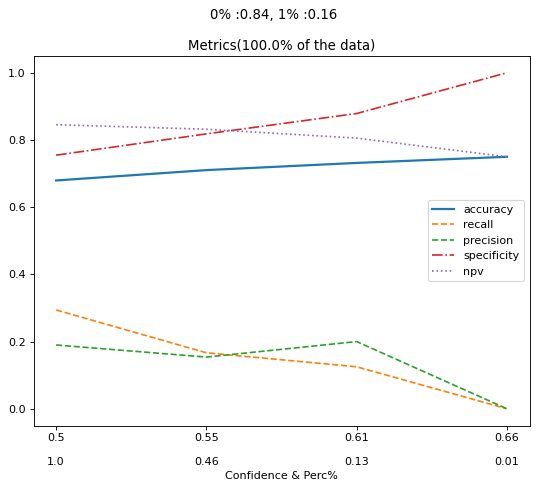

In [28]:
obtain_plot(res, n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)